The general process/outline for this project.

* Will be using DEC (Deep Embedding for Clustering). This will make use of (tinyVgg model architecture) that also combines auto encoders to cluster the images into the labels.




1. Install the necessary libraries (abviously) such as torch, torchvision, matplotlib, numpy

# Make an autoencoder

In [1]:
# Import necessary library
import torch
from torch import nn
import matplotlib.pyplot as plt
import torchvision

In [2]:
# Initalize the GPU for the model
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# device = 'cpu'
device

'cuda'

In [3]:
# Encoder Model Class

class Encoder(nn.Module):
    def __init__(self,
                 input_shape,
                 hidden_units=[256, 128, 64, 32, 16],
                 dropout_rate=0.2,
                 activation=nn.ReLU()):
        super().__init__()

        self.input_shape = input_shape

        self.input_layer = nn.Linear(input_shape, hidden_units[0])

        self.n_layers = 0
        for i in range(len(hidden_units)-1):
            setattr(self, f'hidden_{i}', nn.Linear(hidden_units[i], hidden_units[i+1]))
            self.n_layers += 1
        
        
        self.activation = activation
        self.dropout_rate = dropout_rate
        self.hidden_units = hidden_units

        self.dropout = nn.Dropout(self.dropout_rate) 

        self.flatten = nn.Flatten()  

    def forward(self, x):
        x = self.flatten(x)
        x = self.activation(self.input_layer(x))
        for i in range(self.n_layers-1):
            hidden_layer = getattr(self, f'hidden_{i}')
            x = self.activation(hidden_layer(x))
            x = self.dropout(x)

        # Last layer to get the output without applying the activation funtion
        output_layer = getattr(self, f'hidden_{self.n_layers - 1}')
        x = output_layer(x)
        return x


model_encoder = Encoder(28*28).to(device)

In [4]:
# Convert a sample image to Tensor so we can pass it thorugh our encoder to access that our model is working correctly

from torchvision import transforms
from PIL import Image

image = Image.open('image.jpg')

image_transform = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.Grayscale(),
    transforms.ToTensor()
])

image = image_transform(image)

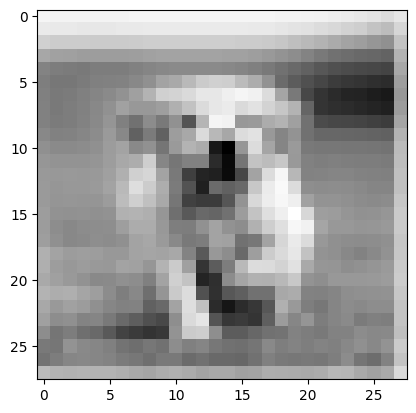

In [5]:
# Print out our transformed image

plt.imshow(image.permute(1, 2, 0), cmap='grey')

In [6]:
# Print out the model class initialization

model_encoder

Encoder(
  (input_layer): Linear(in_features=784, out_features=256, bias=True)
  (hidden_0): Linear(in_features=256, out_features=128, bias=True)
  (hidden_1): Linear(in_features=128, out_features=64, bias=True)
  (hidden_2): Linear(in_features=64, out_features=32, bias=True)
  (hidden_3): Linear(in_features=32, out_features=16, bias=True)
  (activation): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
)

In [7]:
# Getting our image dimensions ready to pass into the encoder
image = image.to(device)
image = image.unsqueeze(dim=0)
image.shape
# flatten = nn.Flatten()
# flat_image = flatten(image)
# flat_image.shape


torch.Size([1, 1, 28, 28])

In [8]:
# the output of our encoder model when we pass the image
output = model_encoder(image)
output.shape

torch.Size([1, 16])

In [9]:
# Decoder Model Class
class Decoder(nn.Module):
    def __init__(self, encoder, activation=nn.ReLU()):
        super().__init__()

        self.n_layers = encoder.n_layers

        self.hidden_units = encoder.hidden_units

        self.hidden_units = self.hidden_units[::-1]

        self.input_shape = encoder.input_shape

        for i in range(self.n_layers):
            setattr(self, f'hidden_{i}', nn.Linear(self.hidden_units[i],
                                                   self.hidden_units[i+1]))
            
        self.output_layer = nn.Linear(self.hidden_units[i+1], self.input_shape)

        self.dropout = encoder.dropout
        self.activation = activation
    
    def forward(self, x):
        
        for i in range(self.n_layers):
            hidden_layer = getattr(self, f'hidden_{i}')
            x = hidden_layer(x)
            x = self.activation(x)
            x = self.dropout(x)
        
        output = self.output_layer(x)
        return output



In [10]:
# Instanciate our decoder model class
model_decoder = Decoder(model_encoder).to(device)

In [11]:
# Print out the model class initialization
model_decoder

Decoder(
  (hidden_0): Linear(in_features=16, out_features=32, bias=True)
  (hidden_1): Linear(in_features=32, out_features=64, bias=True)
  (hidden_2): Linear(in_features=64, out_features=128, bias=True)
  (hidden_3): Linear(in_features=128, out_features=256, bias=True)
  (output_layer): Linear(in_features=256, out_features=784, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (activation): ReLU()
)

In [12]:
# Passing the output of our encoder into the decoder

decoder_output = model_decoder(output)
decoder_output.shape

torch.Size([1, 784])

In [13]:
# reshaping the output of the decoder into the shape of the original image 
reshaped_output = decoder_output.reshape(1, 28, 28).detach().cpu()

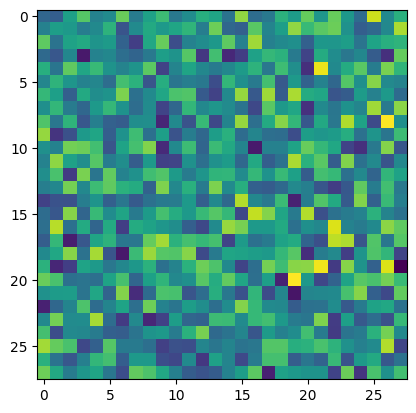

In [14]:
# Print our the reshaped decoder output

plt.imshow(reshaped_output.permute(1, 2, 0))

In [15]:
# AutoEncoder Model Class

class AutoEncoder(nn.Module):
    def __init__(self, input_shape):
        super().__init__()

        self.encoder = Encoder(input_shape=input_shape)

        self.decoder = Decoder(self.encoder)

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded


In [16]:
# Instanciate the AutoEncoder model class

model_autoencoder = AutoEncoder(input_shape=28*28).to(device)

In [17]:
# Download the MNIST dataset

from torchvision import datasets
from torch.utils.data import ConcatDataset


train_data = datasets.MNIST(root='./',
                            train=True,
                            transform=torchvision.transforms.ToTensor(),
                            target_transform=None,
                            download=True)

test_data = datasets.MNIST(root='./',
                           train=False,
                           transform=torchvision.transforms.ToTensor(),
                           target_transform=None,
                           download=True)

dataset = ConcatDataset([train_data, test_data])

In [18]:
# Create dataloaders form the dataset

from torch.utils.data import DataLoader

BATCH_SIZE = 32

train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              shuffle=True)

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=BATCH_SIZE,
                             shuffle=False)

dataloader = DataLoader(dataset=dataset,
                        batch_size=BATCH_SIZE,
                        shuffle=True)

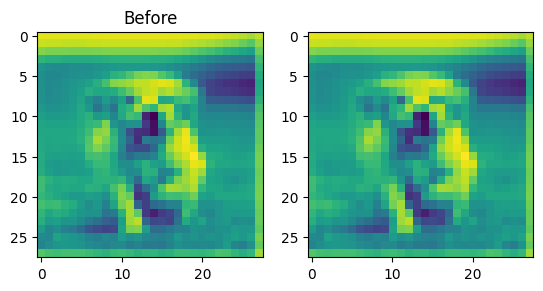

In [19]:
# Testing out what a normalization does to an image

normalize = transforms.Normalize(0.5, 0.5)
normalize_output = normalize(image.squeeze(dim=0))


plt.subplot(1, 2, 1)
plt.imshow(image.squeeze(dim=0).cpu().permute(1, 2, 0))
plt.title('Before')

plt.subplot(1 , 2, 2)
plt.imshow(normalize_output.cpu().permute(1, 2, 0))

In [20]:
# Initialize the loss function, optimizer and the scheduler

from torch.optim import lr_scheduler

loss_fn = nn.MSELoss()
optimizer = torch.optim.SGD(params=model_autoencoder.parameters(),
                            lr=0.1)

scheduler = lr_scheduler.StepLR(optimizer=optimizer, step_size=5, gamma=0.1)

In [21]:
# Train our autoencoder model

num_epochs = 10

# list of loss for each epochs so we can compare it later in graph
loss_for_graph = []


for epoch in range(num_epochs):
    model_autoencoder.train()

    train_loss = 0
    
    
    
    for index, (image, label) in enumerate(train_dataloader):

        image, label = image.to(device), label.to(device)


        image = image.view(image.shape[0], -1) # .view() is used to reshape tensor in python. the resulting number of values is preserved in the .view(). -1 is used as input parameter in the case to let the python decide what dimension make sense to put there as to preserve the total number of values in the resulting tensor. say i have an tensor of shape (3, 100, 100, 75) and then i put the `.view(3, -1)` then the python would reshape it into the (3, 100*100*75) which is shape (3, 750000)


        model_output = model_autoencoder(image)

        loss = loss_fn(model_output[1], image)

        train_loss += loss

        

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if index % 250 == 0:
            print(f'{index+1}/{len(train_dataloader)}')
        
    scheduler.step()
    
    train_loss /= len(train_dataloader)

    loss_for_graph.append(train_loss.item())

    print(f'Epoch: {epoch} | Loss: {train_loss:.4f}')


1/1875
251/1875
501/1875
751/1875
1001/1875
1251/1875
1501/1875
1751/1875
Epoch: 0 | Loss: 0.0840
1/1875
251/1875
501/1875
751/1875
1001/1875
1251/1875
1501/1875
1751/1875
Epoch: 1 | Loss: 0.0695
1/1875
251/1875
501/1875
751/1875
1001/1875
1251/1875
1501/1875
1751/1875
Epoch: 2 | Loss: 0.0689
1/1875
251/1875
501/1875
751/1875
1001/1875
1251/1875
1501/1875
1751/1875
Epoch: 3 | Loss: 0.0686
1/1875
251/1875
501/1875
751/1875
1001/1875
1251/1875
1501/1875
1751/1875
Epoch: 4 | Loss: 0.0684
1/1875
251/1875
501/1875
751/1875
1001/1875
1251/1875
1501/1875
1751/1875
Epoch: 5 | Loss: 0.0683
1/1875
251/1875
501/1875
751/1875
1001/1875
1251/1875
1501/1875
1751/1875
Epoch: 6 | Loss: 0.0683
1/1875
251/1875
501/1875
751/1875
1001/1875
1251/1875
1501/1875
1751/1875
Epoch: 7 | Loss: 0.0683
1/1875
251/1875
501/1875
751/1875
1001/1875
1251/1875
1501/1875
1751/1875
Epoch: 8 | Loss: 0.0682
1/1875
251/1875
501/1875
751/1875
1001/1875
1251/1875
1501/1875
1751/1875
Epoch: 9 | Loss: 0.0682


(0.0, 0.1)

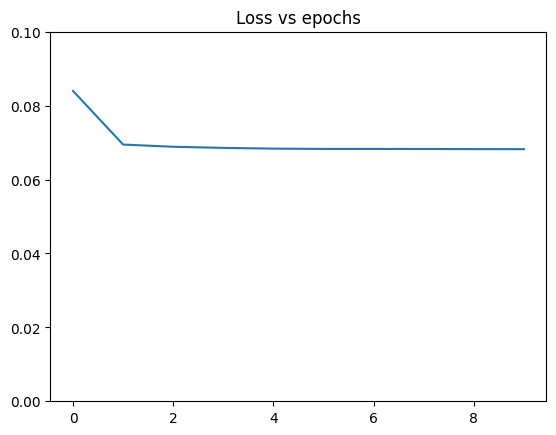

In [22]:
# Graph of loss over time (epochs)

plt.plot(range(num_epochs), loss_for_graph)
plt.title('Loss vs epochs')
plt.ylim(0, 0.1)

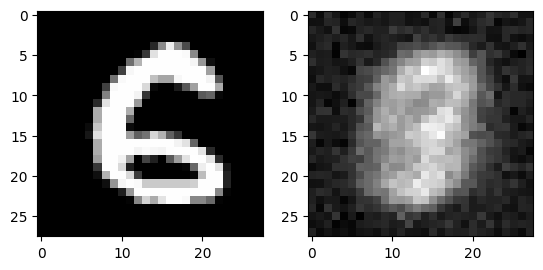

In [23]:
# print out the output of our autoencoder when an image is passed thorugh it

image, label = train_data[10044]

plt.subplot(1, 2, 1)
plt.imshow(image.permute(1, 2, 0), cmap='grey')

output = model_autoencoder(image.to(device))
output = output[1].reshape(1, 28, 28)
output = output.detach().cpu()

plt.subplot(1, 2, 2)
plt.imshow(output.permute(1, 2, 0), cmap='grey')


In [24]:
# Get all the encoded output for all of our input images
# Also get the labels of images, so we can compare the accuracy of the model as it classifies the latent representation of the model(unsupervised learning) into the labels

with torch.inference_mode():
    model_autoencoder.eval()

    encoded_data = []
    label_data = []
    for image, label in train_dataloader:
        image = image.to(device)

        encoded_batch = model_autoencoder(image)[0].detach().cpu()
        # print(encoded_batch.shape)
        encoded_data += encoded_batch
        label_data += label
       
encoded_data = torch.stack(encoded_data)
label_data = torch.stack(label_data)

encoded_data.shape, label_data.shape


(torch.Size([60000, 16]), torch.Size([60000]))

In [25]:
# apply kmeans clustering on our encoded 

from sklearn.cluster import KMeans

n_clusters = 10

kmeans = KMeans(n_clusters=n_clusters)

cluster_labels = kmeans.fit_predict(encoded_data)

In [26]:
# Get the ami(adjusted mutual info) score for the clustering

from sklearn.metrics import adjusted_mutual_info_score

ami_score = adjusted_mutual_info_score(label_data, cluster_labels)

print(f'{ami_score*100:.2f} %')

13.80 %


In [27]:
cluster_labels = torch.tensor(cluster_labels)

In [28]:
cluster_labels

tensor([8, 2, 4,  ..., 6, 8, 5], dtype=torch.int32)

In [29]:
# make and plot the confusion matrix bwtween the cluster labels and the true labels

from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

confusion_matrix = ConfusionMatrix(task='multiclass', num_classes=10)

confusion_matrix_tensor = confusion_matrix(cluster_labels, label_data)

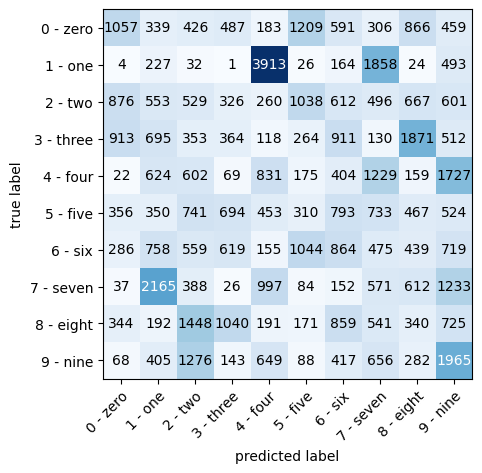

In [30]:
# Plot the confusion matrix
fig, ax = plot_confusion_matrix(
    conf_mat=confusion_matrix_tensor.numpy(),
    class_names=test_data.classes
)

In [31]:
confusion_matrix_tensor.shape
confusion_matrix_tensor[9, 9]

# Get all the number of correct predicted labels in the unsupervised learning 
correct = []
for i in range(len(train_data.classes)):
    x = confusion_matrix_tensor[i, i].item()
    # print(x)
    correct.append(x)

correct

[1057, 227, 529, 364, 831, 310, 864, 571, 340, 1965]

In [32]:
total = 0
total += sum(correct)
total

7058

In [33]:
# get the accuracy of the model
Accuracy = (total/len(train_data)) * 100
print(f'Model Accuracy: {Accuracy:.2f} %')

Model Accuracy: 11.76 %
